In [110]:
%reload_ext autoreload
%autoreload 2

import os
import wandb
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib.ticker import ScalarFormatter
from core.experiments import RunFactory

sns.set(context='paper', 
        style='ticks', 
        palette='deep', 
        font='Linux Libertine O', 
        font_scale=2.5, 
        rc={
            'mathtext.fontset': 'stix',
            'lines.linewidth' : 4,
            'lines.markersize' : 12,
        }
)
sns.despine()
os.makedirs('figs', exist_ok=True)

<Figure size 432x288 with 0 Axes>

In [2]:
wandb_user = 'sisaman'
wandb_project = 'GAP-ATTACK'

run_factory = RunFactory(
    main_file='attack.py', 
    entity=wandb_user,
    project=wandb_project, 
    check_existing=True
)

# Experiments

### Hyper-parameters

In [3]:
datasets = ['facebook', 'reddit', 'amazon']
batch_size = 256


gap_methods  = ['gap-inf', 'gap-ndp']
sage_methods = ['sage-inf', 'sage-ndp']
mlp_methods  = ['mlp', 'mlp-dp']
ndp_methods  = ['gap-ndp', 'sage-ndp', 'mlp-dp']
all_methods  = gap_methods + sage_methods + mlp_methods

hparams = {dataset: {method: {} for method in all_methods} for dataset in datasets}

for dataset in datasets:
    # For GAP methods
    for method in gap_methods:
        hparams[dataset][method]['target_encoder_layers'] = 2
        hparams[dataset][method]['target_base_layers'] = 1
        hparams[dataset][method]['target_head_layers'] = 1
        hparams[dataset][method]['target_combine'] = 'cat'
        hparams[dataset][method]['target_hops'] = 2

    # For SAGE methods
    for method in sage_methods:
        hparams[dataset][method]['target_base_layers'] = 2
        hparams[dataset][method]['target_head_layers'] = 1
        if method != 'sage-ndp':
            hparams[dataset][method]['target_mp_layers'] = 2
        
    # For MLP methods
    for method in mlp_methods:
        hparams[dataset][method]['target_num_layers'] = 3

    # For GAP-NDP and SAGE-NDP
    for method in ['gap-ndp', 'sage-ndp']:
        hparams[dataset][method]['target_max_degree'] = 100

    # For all methods
    for method in all_methods:
        hparams[dataset][method]['target_hidden_dim'] = 64
        hparams[dataset][method]['target_activation'] = 'selu'
        hparams[dataset][method]['target_optimizer'] = 'adam'
        hparams[dataset][method]['target_learning_rate'] = 0.01
        
        if method in ndp_methods:
            hparams[dataset][method]['target_max_grad_norm'] = 1
            hparams[dataset][method]['target_epochs'] = 10
            hparams[dataset][method]['target_batch_size'] = 256

        else:
            hparams[dataset][method]['target_batch_norm'] = True
            hparams[dataset][method]['target_epochs'] = 100
            hparams[dataset][method]['target_batch_size'] = 'full'

        if method != 'sage-ndp':
            hparams[dataset][method]['target_val_interval'] = 0

        if method in gap_methods:
            hparams[dataset][method]['target_encoder_epochs'] = hparams[dataset][method]['target_epochs']

        hparams[dataset][method]['num_nodes_per_class'] = 1000
        hparams[dataset][method]['retain_target_data'] = [False]
        hparams[dataset][method]['attack_hidden_dim'] = 64
        hparams[dataset][method]['attack_num_layers'] = 3
        hparams[dataset][method]['attack_activation'] = 'selu'
        hparams[dataset][method]['attack_batch_norm'] = True
        hparams[dataset][method]['attack_batch_size'] = 'full'
        hparams[dataset][method]['attack_epochs'] = 100
        hparams[dataset][method]['attack_optimizer'] = 'adam'
        hparams[dataset][method]['attack_learning_rate'] = 0.01
        hparams[dataset][method]['attack_val_interval'] = 1
        hparams[dataset][method]['repeats'] = 10


### Attack Experiments

In [4]:
for dataset in datasets:
    for method in all_methods:
        params = {}
        if method in ndp_methods:
            params['target_epsilon'] = [1, 2, 4, 8, 16]
        
        run_factory.register(
            method, 
            'nmi',
            dataset=dataset,
            **params, 
            **hparams[dataset][method]
        )

run_factory.save(path='jobs/gap-attack.sh')

Saved 0 runs to jobs/gap-attack.sh


### Results

In [5]:
api = wandb.Api()
runs = api.runs(f"{wandb_user}/{wandb_project}", per_page=2000)

data_list = []
for run in runs: 
    data = {}
    data.update(run.summary._json_dict)
    data.update(run.config)
    data_list.append(data)

In [125]:
cols = ['dataset', 'method', 'target_epsilon', 'attack/test/auc_mean']
df = pd.DataFrame(data_list, columns=cols)
df = df.fillna(np.inf)
df = df.rename(columns={
    'target_epsilon': 'epsilon', 
    'attack/test/auc_mean': 'auc', 
})
df['method'] = df['method'].apply(lambda x: {'GAP': 'GAP-NDP', 'SAGE': 'SAGE-NDP', 'MLP': 'MLP-DP'}[x.upper().split('-')[0]])
df['auc'] = df.apply(lambda row: f"{row['auc']:.2f}", axis=1)

def sort_key(row):
    keys = {
        'Facebook': 1, 'Reddit': 2, 'Amazon': 3,     # datasets
        'GAP-NDP': 1, 'SAGE-NDP': 2, 'MLP-DP': 3,             # methods
    }
    if isinstance(row, pd.Index):
        s = row.to_series()
        s = s.replace(keys)
        return pd.Index(s)
    else:
        return row.replace(keys)

df['dataset'] = df['dataset'].str.title()
df = df.pivot(columns=['epsilon'], index=['dataset', 'method'])
df = df.reset_index().sort_values(by=['dataset', 'method'], key=sort_key)
df = df.set_index(['dataset', 'method'])
df = df.droplevel(0, axis=1)
df = df.rename_axis(index=str.title)
df = df.rename(lambda eps: f"$\epsilon={eps:.0f}$", axis='columns')
df = df.rename({'$\epsilon=inf$': '$\epsilon=\infty$'}, axis='columns')
print(df.to_latex(escape=False, multirow=True))
df

[20:18:42] WARNING  /idiap/temp/sajadmanesh/.tmp/ipykernel_62973/1308209719.py:31: FutureWarning:   ]8;id=766934;file:///remote/idiap.svm/temp.social02/sajadmanesh/conda/envs/gap/lib/python3.9/warnings.py\warnings.py]8;;\:]8;id=189037;file:///remote/idiap.svm/temp.social02/sajadmanesh/conda/envs/gap/lib/python3.9/warnings.py#109\109]8;;\
                    In future versions `DataFrame.to_latex` is expected to utilise the base                        
                    implementation of `Styler.to_latex` for formatting and rendering. The arguments                
                    signature may therefore change. It is recommended instead to use                               
                    `DataFrame.style.to_latex` which also contains additional functionality.                       
                      print(df.to_latex(escape=False, multirow=True))                                              
                                                                                                                   

\begin{tabular}{llllllll}
\toprule
       & epsilon & $\epsilon=1$ & $\epsilon=2$ & $\epsilon=4$ & $\epsilon=8$ & $\epsilon=16$ & $\epsilon=\infty$ \\
Dataset & Method &              &              &              &              &               &                   \\
\midrule
\multirow{3}{*}{Facebook} & GAP-NDP &        50.16 &        50.25 &        50.61 &        51.11 &         52.66 &             81.67 \\
       & SAGE-NDP &        50.25 &        50.20 &        50.23 &        50.17 &         50.20 &             62.49 \\
       & MLP-DP &        50.32 &        50.72 &        52.13 &        53.44 &         54.77 &             81.57 \\
\cline{1-8}
\multirow{3}{*}{Reddit} & GAP-NDP &        50.04 &        50.39 &        51.20 &        52.23 &         52.54 &             54.97 \\
       & SAGE-NDP &        49.97 &        49.97 &        49.95 &        50.00 &         49.98 &             50.05 \\
       & MLP-DP &        51.25 &        53.09 &        55.13 &        56.72 &         58.32 &  

epsilon           $\epsilon=1$ $\epsilon=2$ $\epsilon=4$ $\epsilon=8$  \
Dataset  Method                                                         
Facebook GAP-NDP         50.16        50.25        50.61        51.11   
         SAGE-NDP        50.25        50.20        50.23        50.17   
         MLP-DP          50.32        50.72        52.13        53.44   
Reddit   GAP-NDP         50.04        50.39        51.20        52.23   
         SAGE-NDP        49.97        49.97        49.95        50.00   
         MLP-DP          51.25        53.09        55.13        56.72   
Amazon   GAP-NDP         50.06        50.23        50.54        51.53   
         SAGE-NDP        49.93        49.93        49.93        49.92   
         MLP-DP          50.30        50.58        51.43        52.31   

epsilon           $\epsilon=16$ $\epsilon=\infty$  
Dataset  Method                                    
Facebook GAP-NDP          52.66             81.67  
         SAGE-NDP         50.20             62.49  
         MLP-DP           54.77             81.57  
Reddit   GAP-NDP          52.54             54.97  
         SAGE-NDP         49.98             50.05  
         MLP-DP           58.32             71.35  
Amazon   GAP-NDP          51.72             66.68  
         SAGE-NDP         49.97             59.41  
         MLP-DP           53.34             72.97

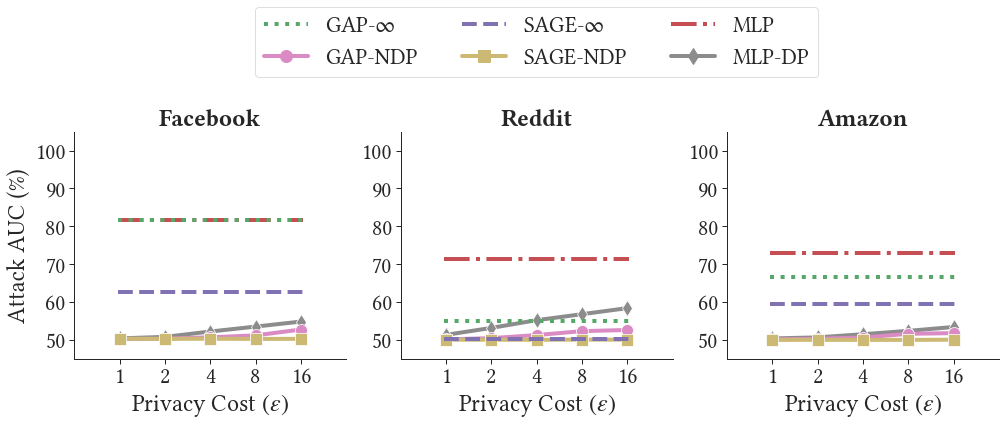

In [111]:
cols = ['dataset', 'method', 'target_epsilon', 'attack/test/auc_mean']
datasets = ['facebook', 'reddit', 'amazon']
methods = ['GAP-$\infty$', 'GAP-NDP', 'SAGE-$\infty$', 'SAGE-NDP', 'MLP', 'MLP-DP']
epsilons = [1, 2, 4, 8, 16]

df = pd.DataFrame(data_list, columns=cols)
df = df.fillna(np.inf)
df = df.rename(columns={
    'target_epsilon': 'epsilon', 
    'attack/test/auc_mean': 'auc'
})
df['method'] = df['method'].apply(str.upper)
df['method'] = df['method'].apply(lambda method: method.replace('INF', '$\infty$'))

inf_auc = df.loc[df['method'].isin(['GAP-$\infty$', 'SAGE-$\infty$', 'MLP']), ['dataset', 'method', 'auc']].set_index(['dataset', 'method'])
ndp_methods = ['MLP-DP', 'GAP-NDP', 'SAGE-NDP']
df = df.loc[df['method'].isin(ndp_methods)]
df['epsilon'] = df['epsilon'].astype(int)

palette = sns.color_palette()
g = sns.relplot(kind='line', data=df, x='epsilon', y='auc', hue='method', col='dataset', aspect=1.2,
                markers=['d', 'o', 's'], dashes=False, style='method',
                hue_order=ndp_methods, col_order=datasets, style_order=ndp_methods, 
                palette=[palette[-3], palette[-4], palette[-2]],
                facet_kws={'sharey': False, 'sharex': False})

g.set(ylabel=None, xlabel='Privacy Cost $(\epsilon)$', xscale='log', xticks=epsilons, xlim=(epsilons[0] / 2, epsilons[-1] * 2), ylim=(45,105), yticks=range(50,110,10))

for dataset, ax in zip(datasets, g.axes[0]):
    ax.axhline(inf_auc.loc[(dataset, 'SAGE-$\infty$')].item(), linestyle='dashed', label='SAGE-$\infty$', color=sns.color_palette('deep')[4], xmin=0.16, xmax=0.84)
    ax.axhline(inf_auc.loc[(dataset, 'MLP')].item(), linestyle='dashdot', label='MLP', color=sns.color_palette('deep')[3], xmin=0.16, xmax=0.84)
    ax.axhline(inf_auc.loc[(dataset, 'GAP-$\infty$')].item(), linestyle='dotted', label='GAP-$\infty$', color=sns.color_palette('deep')[2], xmin=0.16, xmax=0.84)
    ax.set_title(label=dataset.capitalize(), fontdict={'fontweight': 'bold'}, )
    ax.get_xaxis().set_major_formatter(ScalarFormatter())
    ax.minorticks_off()

handles, labels = g.axes[0][0].get_legend_handles_labels()
legend_data = {label: handle for label, handle in zip(labels, handles)}
g.legend.remove()
g.axes[0][1].legend(loc='upper center', ncol=3, bbox_to_anchor=(.5, 1.6), handles=[legend_data[method] for method in methods], labels=methods)
g.axes[0][0].set(ylabel='Attack AUC (%)')

g.fig.subplots_adjust(hspace=0.4, wspace=0.2)
g.fig.set_figwidth(16)
g.savefig('figs/attack.pdf')